To analyze the object detection results for the Crowd AI Mapping Challenge dataset, we'll use Fifty One, which is a great tool
for visualizing subsets of a dataset with advanced filtering, and more.

This notebook follows the Fifty One tutorial: [Evaluate detections](https://voxel51.com/docs/fiftyone/tutorials/evaluate_detections.html). We'll also use the
notebook [Using Fifty One in IceVision](https://airctic.com/0.12.0/using_fiftyone_in_icevision/).

Also see the user guide: [Using the Fifty One App](https://voxel51.com/docs/fiftyone/user_guide/app.html).

In this notebook we assume IceVision is already installed and a model has been trained (and saved on wandb) on the small version of the Crowd AI Mapping Challenge dataset
using the wandb-building-detection notebook.

In [1]:
# Enlarge the window to better view images in Fifty One.
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Work in the project directory to avoid file not found errors.

In [38]:
%cd ..

# Inference with Fiftyone and IceVision


`fiftyone` is not part of IceVision. We need to install it separately.

In [ ]:
# Install fiftyone
%pip install fiftyone -U

In [ ]:
# Restart kernel after installation
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

## Imports
All of the IceVision components can be easily imported with a single line.


In [1]:
from icevision import data
from icevision.all import *
from icevision.models import * # Needed for inference later
from fastai.callback.wandb import *
import icedata  # Needed for sample data
import fiftyone as fo

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /home/krajarat/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17
INFO     - The mmseg config folder already exists. No need to downloaded it. Path : /home/krajarat/.icevision/mmsegmentation_configs/mmsegmentation_configs-0.17.0/configs | icevision.models.mmseg.download_configs:download_mmseg_configs:19


## Load the Parser and Dataset

Set the `data_dir` variable to "../data/train" to analyze the validation set, or "data/val" to analyze the test set.

In [15]:
data_dir = "data/val"

In [16]:
# Create the parser
parser = parsers.COCOBBoxParser(annotations_filepath= data_dir + "/annotation-small3.json", img_dir= data_dir + "/images")

In [17]:
# Parse annotations to create records
data_splitter = data.SingleSplitSplitter()
records = None
if data_dir == "data/train":
    data_splitter=RandomSplitter([0.8, 0.2], seed=42)
    _, records = parser.parse(data_splitter=data_splitter, cache_filepath= data_dir +  "/cache-records3.p")
else:
    records = parser.parse(cache_filepath= data_dir +  "/cache-records3.p")[0]
parser.class_map

INFO     - Loading cached records from data/val/cache-records3.p | icevision.parsers.parser:parse:113


<ClassMap: {'background': 0, 'building': 1}>

In [18]:
len(records)

1820

In [19]:
# Transforms
image_size = 384

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [20]:
# Datasets
records_ds = Dataset(records, valid_tfms)

## Initalize and load model from wandb

In [21]:
# Library and model selection

model_type = models.ultralytics.yolov5
backbone = model_type.backbones.medium
# The yolov5 model requires an img_size parameter
extra_args = {'img_size' : image_size}

model = model_type.model(backbone=backbone(pretrained=true), num_classes=len(parser.class_map), **extra_args) 

Overriding model.yaml nc=80 with nc=1

                 from  n    params  module                                  arguments                     
  0                -1  1      5280  yolov5.models.common.Conv               [3, 48, 6, 2, 2]              
  1                -1  1     41664  yolov5.models.common.Conv               [48, 96, 3, 2]                
  2                -1  2     65280  yolov5.models.common.C3                 [96, 96, 2]                   
  3                -1  1    166272  yolov5.models.common.Conv               [96, 192, 3, 2]               
  4                -1  4    444672  yolov5.models.common.C3                 [192, 192, 4]                 
  5                -1  1    664320  yolov5.models.common.Conv               [192, 384, 3, 2]              
  6                -1  6   2512896  yolov5.models.common.C3                 [384, 384, 6]                 
  7                -1  1   2655744  yolov5.models.common.Conv               [384, 768, 3, 2]             

In [22]:
# DataLoader
records_dl = model_type.valid_dl(records_ds, batch_size=16, num_workers=4, shuffle=False)

Now download the model from wandb, after making appropriate changes to `user_name`, `project_name`, and `run_id` below.

In [ ]:
import wandb
run = wandb.init()
user_name = "john"
project_name = "mappingchallenge"
run_id = "123456"
artifact = run.use_artifact(f'{user_name}/{project_name}/run-{run_id}-model:v0', type='model')
artifact_dir = artifact.download()

In [23]:
learn = model_type.fastai.learner(dls=[records_dl], model=model, 
                                  metrics=[COCOMetric(metric_type=COCOMetricType.bbox)])

We'll use 'ultralytics-yolov5-example.pth' included with this repo. First unzip it before running the line below.

In [24]:
learn.load('ultralytics-yolov5-example')

/home/krajarat/miniconda3/envs/icevision/lib/python3.8/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/home/krajarat/miniconda3/envs/icevision/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


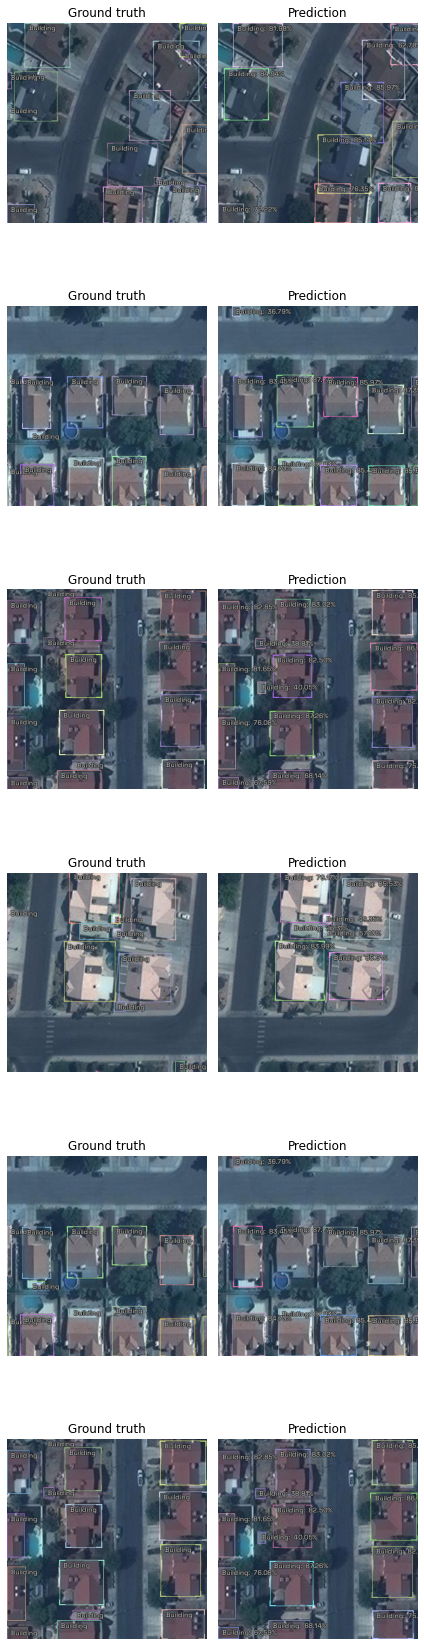

In [25]:
%matplotlib inline
model_type.show_results(model, records_ds)

## Visualizing predictions

We'll visualize predictions by calling the `icevision.data.create_fo_dataset` with an `icevision.Prediction`.

Predictions for building detection.

In [26]:
infer_dl = model_type.infer_dl(records_ds, batch_size=8)
preds = model_type.predict_from_dl(model=model, infer_dl=infer_dl, keep_images=True)

  0%|          | 0/3 [00:00<?, ?it/s]

In [27]:
fo_dataset_name = "building_detection"

In [29]:
# Let's create a dataset with our predictions.

fo_dataset = data.create_fo_dataset(detections=preds,
                                   dataset_name=fo_dataset_name,
                                   exist_ok=True,
                                   transformations=valid_tfms.tfms_list)  # Use IceVisions automatic postprocess bbox function by adding the tfms_list

 100% |███████████████████| 24/24 [353.9ms elapsed, 0s remaining, 68.8 samples/s]      


In [30]:
# List datasets
fo.list_datasets()

['building_detection']

Uncomment the line below to visualize predictions on this dataset.

In [34]:
#fo.launch_app(fo_dataset)

### Analyze high confidence predictions

`high_conf_view` consists only of the predicted bounding boxes with a probability score greater than $0.75$.

In [35]:
from fiftyone import ViewField as F

predictions_view = fo_dataset.take(len(fo_dataset), seed=51)
high_conf_view = predictions_view.filter_labels("prediction", F("confidence") > 0.75)

Uncomment the line below to view the high confidence detections.

In [37]:
#fo.launch_app(dataset=fo_dataset, view=high_conf_view)

In [43]:
# Evaluate the predictions in the `prediction` field of our `high_conf_view`
# with respect to the objects in the `ground_truth` field
results = high_conf_view.evaluate_detections(
    "prediction",
    gt_field="ground_truth",
    eval_key="eval",
    compute_mAP=True,
)

Evaluating detections...
 100% |███████████████| 1517/1517 [1.4m elapsed, 0s remaining, 27.4 samples/s]       
Performing IoU sweep...
 100% |███████████████| 1517/1517 [1.2m elapsed, 0s remaining, 24.1 samples/s]       


In [44]:
results.print_report()

              precision    recall  f1-score   support

    building       0.99      0.46      0.63     14789

   micro avg       0.99      0.46      0.63     14789
   macro avg       0.99      0.46      0.63     14789
weighted avg       0.99      0.46      0.63     14789



In [45]:
print(results.mAP())

0.33735380781600566


In [175]:
plot = results.plot_pr_curves()
plot.show()

FigureWidget({
    'data': [{'customdata': array([    0.91269,     0.88068,     0.87384,     0.86739,     0.85…

In [45]:
plot.freeze()

### Analyze all predictions

In [46]:
results = predictions_view.evaluate_detections(
    "prediction",
    gt_field="ground_truth",
    eval_key="eval",
    compute_mAP=True,
)

Evaluating detections...
 100% |███████████████| 1820/1820 [2.0m elapsed, 0s remaining, 40.9 samples/s]      
Performing IoU sweep...
 100% |███████████████| 1820/1820 [1.9m elapsed, 0s remaining, 19.9 samples/s]      


In [47]:
results.print_report()

              precision    recall  f1-score   support

    building       0.85      0.76      0.80     15650

   micro avg       0.85      0.76      0.80     15650
   macro avg       0.85      0.76      0.80     15650
weighted avg       0.85      0.76      0.80     15650



In [48]:
print(results.mAP())

0.49411739109866887


In [49]:
plot = results.plot_pr_curves()
plot.show()

FigureWidget({
    'data': [{'customdata': array([    0.91269,     0.88019,     0.87305,     0.86638,     0.85…

In [50]:
plot.freeze()

View the worst-performing samples

In [52]:
#fo.launch_app(dataset=fo_dataset, view=predictions_view.sort_by("eval_fn", reverse=True))

### Filter by small bounding boxes

In [65]:
# Compute metadata so we can reference image height/width in our view
fo_dataset.compute_metadata()

Computing image metadata...
 100% |███████████████████| 24/24 [384.4ms elapsed, 0s remaining, 62.4 samples/s]      


In [66]:
bbox_area = (
    F("$metadata.width") * F("bounding_box")[2] *
    F("$metadata.height") * F("bounding_box")[3]
)
small_boxes = bbox_area < 32 ** 2

In [180]:
# Create a view that contains only small (and high confidence) predictions
#fo.launch_app(dataset=fo_dataset, view=predictions_view.filter_labels("prediction", small_boxes).sort_by("eval_fp", reverse=True))

### Cleanup

In [165]:
fo.delete_dataset(fo_dataset_name)